In [5]:
from google.colab import files
uploaded = files.upload()

Saving animeface.zip to animeface.zip


In [8]:
import os
print("Isi folder /content sekarang:")
print(os.listdir("/content"))


Isi folder /content sekarang:
['.config', 'anime_faces', 'animeface.zip', 'C:\\Users\\zakii\\Downloads\\anime_faces_subset', 'sample_data']


In [11]:
import zipfile, os

zip_path = "/content/animeface.zip"
extract_to = "/content/anime_faces"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Ekstraksi selesai!")
print("Isi folder hasil ekstraksi:")
print(os.listdir(extract_to))


✅ Ekstraksi selesai!
Isi folder hasil ekstraksi:
['data']


Found 34482 images belonging to 1 classes.
Found 8620 images belonging to 1 classes.
Epoch 1/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - loss: 0.0225 - val_loss: 0.0087
Epoch 2/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 3/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 4/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 5/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 7/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 8/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 9/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 10/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 11/20
10

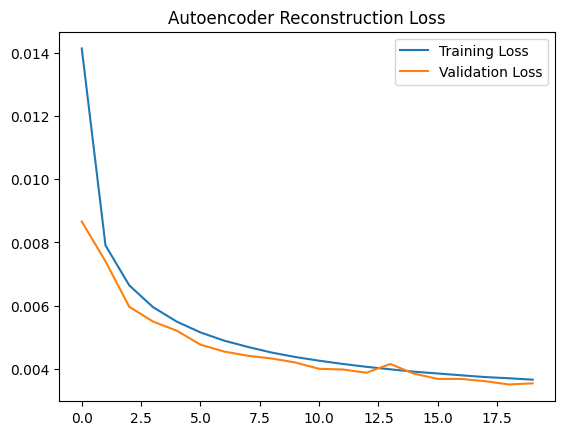

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# --- Direktori dataset ---
dataset_dir = '/content/anime_faces'

# --- Data Generator (tanpa label) ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,
    subset='validation',
    shuffle=True
)

# --- Autoencoder ---
input_img = Input(shape=(64, 64, 3))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# --- Training manual (tanpa y) ---
def generator_pair(gen):
    """Generator yang mengembalikan (x, x) untuk autoencoder"""
    for batch in gen:
        yield (batch, batch)

train_gen_auto = generator_pair(train_gen)
val_gen_auto = generator_pair(val_gen)

# --- Train ---
history = autoencoder.fit(
    train_gen_auto,
    validation_data=val_gen_auto,
    epochs=20,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen)
)

# --- Plot hasil ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Autoencoder Reconstruction Loss')
plt.show()
